# Simulation 1: amplitudes, number of events and tolerance levels

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import  hmp
import bambi as bmb 
import pandas as pd
import arviz as az
from os import listdir
import mne
from hmp import simulations
from scipy.stats import gamma
from itertools import product
from seaborn import color_palette

colors = iter([plt.cm.tab10(i) for i in range(10)])

def fit_or_load(filename, path, model):
    # if filename not in listdir(path):
    fit = model.fit(inference_method='nuts_numpyro')
    #     fit.to_netcdf(path+'/'+filename)
    # else:
    #     fit = az.from_netcdf(path+'/'+filename)
    return fit


Simulating ./simulated/1.5e-07_1trial_raw.fif
./simulated/1.5e-07_1trial_raw.fif simulated
Processing participant ./simulated/1.5e-07_1trial_raw.fif's continuous eeg


/home/gweindel/miniconda3/envs/bays_hmp/lib/python3.11/site-packages/mne/epochs.py:2986: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  metadata.iloc[:, 0] = ""


100 trials were retained for participant ./simulated/1.5e-07_1trial_raw.fif
1.5347551619900333e-06
Simulating ./simulated/5e-07_1trial_raw.fif
./simulated/5e-07_1trial_raw.fif simulated
Processing participant ./simulated/5e-07_1trial_raw.fif's continuous eeg


/home/gweindel/miniconda3/envs/bays_hmp/lib/python3.11/site-packages/mne/epochs.py:2986: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  metadata.iloc[:, 0] = ""


100 trials were retained for participant ./simulated/5e-07_1trial_raw.fif
1.7006865502209407e-06
Simulating ./simulated/1.8e-06_1trial_raw.fif
./simulated/1.8e-06_1trial_raw.fif simulated
Processing participant ./simulated/1.8e-06_1trial_raw.fif's continuous eeg


/home/gweindel/miniconda3/envs/bays_hmp/lib/python3.11/site-packages/mne/epochs.py:2986: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  metadata.iloc[:, 0] = ""


100 trials were retained for participant ./simulated/1.8e-06_1trial_raw.fif
2.9646870474506748e-06


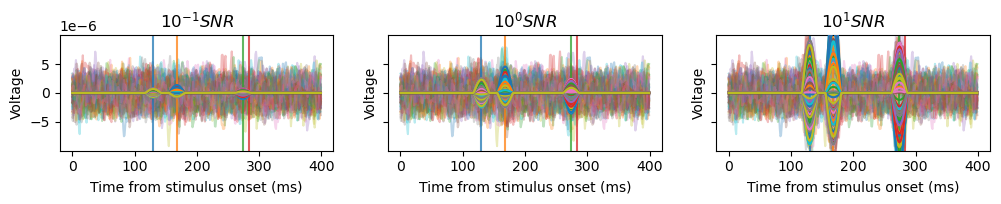

In [68]:
def epoching(data, events, event_id):
    data.load_data()
    data.set_eeg_reference('average')
    epochs = mne.Epochs(data, events = events, event_id=event_id, 
                        tmin = -0.25, tmax=3)
    return epochs

fig, ax = plt.subplots(1,3, figsize=(12,1.5), dpi=100, sharex=True, sharey=True)

source_index = simulations.available_sources()[[34,47,21,44, 42, 14,17, 59, 49,  25, 23, 11]]

n_trials = 100
shape = 2 #shape of the gamma distribution
means = np.repeat(200, len(source_index))/shape #Mean duration of the stages in ms
frequency = 10
sfreq = 500
Nevents = 4
means = np.array([100,100,100,100])/shape #Mean duration of the stages in ms
names = source_index[:4] #Which source to activate at each stage (see atlas when calling simulations.available_sources())
i = 0

for amplitude in [1.5e-7, 5e-7, 1.8e-6]:

    sources = []
    for source in zip(names, means): #One source = one frequency, one amplitude and a given by-trial variability distribution
        sources.append([source[0], frequency, amplitude, gamma(shape, scale=source[1])])

    file = simulations.simulate(sources, n_trials, 5, 'simulated/%s_1trial'%amplitude, 
                                sfreq=sfreq, overwrite=False, noise=True, save_snr=True, seed=3,save_noiseless=True)
    events = np.load(file[1])
    event_id = {'stimulus':1}#trigger 1 = stimulus
    # #Visualising the raw simulated EEG data
    raw_noiseless = mne.io.read_raw_fif(file[-1], preload=False, verbose=False)
    epochs_noiseless = epoching(raw_noiseless, events, event_id)
    epochs_noiseless.load_data()
    raw = mne.io.read_raw_fif(file[0], preload=False, verbose=False)
    snr = np.load(file[2])
    epochs = epoching(raw, events, event_id)
    epochs.load_data()
    
    ax[i].plot(epochs_noiseless.pick_types(eeg=True).get_data(copy=True).T[125:525,:,0], zorder=10)
    ax[i].plot(epochs.pick_types(eeg=True).get_data(copy=True).T[125:525,:,0], alpha=.3)
    ax[i].set_title(r'$10^{%.0f}SNR$'%np.log10(snr.mean()))
    ax[i].set_ylabel('Voltage')
    ax[i].set_yticks([-5e-6,0,5e-6])
    
    # Feeding data and initialize HMP
    #Recover info from simulation
    generating_events = np.load(file[1])
    resp_trigger = int(np.max(np.unique(generating_events[:,2])))#Resp trigger is the last source in each trial
    event_id = {'stimulus':1}#trigger 1 = stimulus
    resp_id = {'response':resp_trigger}#Response is defined as the last trigger in a sequence of events
    #Keeping only stimulus and response triggers
    events = generating_events[(generating_events[:,2] == 1) | (generating_events[:,2] == resp_trigger)]#only retain stimulus and response triggers

    epoch_data = hmp.utils.read_mne_data(file[0], event_id=event_id, resp_id=resp_id, 
                           sfreq=sfreq, events_provided=events, verbose=False)
    hmp_data = hmp.utils.transform_data(epoch_data, apply_standard=False, n_comp=5)
    init = hmp.models.hmp(hmp_data, sfreq=sfreq)#Initialization of the model
    random_source_times, _, _, _ = simulations.simulated_times_and_parameters(generating_events, init)
    random_source_times_cs = random_source_times.cumsum(axis=1)
    
    ev_colors = iter(color_palette(None, Nevents+1))
    snr_dataset = np.zeros((random_source_times.T.shape))*np.nan
    for ev, event in enumerate(random_source_times.T):
        for trial,time in enumerate(event):
            snr_dataset[ev, trial] = np.abs(epoch_data.data[0,trial,:,time].values).mean()
    print(snr_dataset.mean())
    for event in range(Nevents):
        ev_c = next(ev_colors)
        ax[i].vlines(random_source_times_cs[0,event], ymin=1e-5, ymax=-1e-5, color=ev_c, alpha=.75) 
    ax[i].set_ylim(-10e-6,10e-6)
    ax[i].set_xlabel('Time from stimulus onset (ms)')
    i += 1
    

plt.savefig('../../plots/ERPs_all-elec.png',dpi=300,transparent=True,bbox_inches='tight')

## Illustrating the measures

In [15]:
def epoching(data, events, event_id):
    data.load_data()
    data.set_eeg_reference('average')
    epochs = mne.Epochs(data, events = events, event_id=event_id, 
                        tmin = -0.25, tmax=3)
    return epochs

source_index = simulations.available_sources()[[34,47,21,44]]

amplitude = 1e-6
shape = 2 #shape of the gamma distribution
frequency = 10 #half-sine
sfreq = 500 #sampling frequency
n_trials = 200
Nevents = 4
means = np.array([100,100,100,100])/shape #Mean duration of the stages in ms
names = source_index[:Nevents] #Which source to activate at each stage (see atlas when calling simulations.available_sources())
sources = []
for source in zip(names, means): #One source = one frequency, one amplitude and a given by-trial variability distribution
    sources.append([source[0], frequency, amplitude, gamma(shape, scale=source[1])])

file = simulations.simulate(sources, n_trials, 5, 'simulated/%s'%amplitude, 
                            sfreq=sfreq, overwrite=False, noise=True, save_snr=True, seed=4, save_noiseless=True)

#Recover info from simulation
generating_events = np.load(file[1])
resp_trigger = int(np.max(np.unique(generating_events[:,2])))#Resp trigger is the last source in each trial
event_id = {'stimulus':1}#trigger 1 = stimulus
resp_id = {'response':resp_trigger}#Response is defined as the last trigger in a sequence of events
#Keeping only stimulus and response triggers
events = generating_events[(generating_events[:,2] == 1) | (generating_events[:,2] == resp_trigger)]#only retain stimulus and response triggers

#Loading for visualization of the raw simulated EEG data
raw_noiseless = mne.io.read_raw_fif(file[-1], preload=False, verbose=False)
epochs_noiseless = epoching(raw_noiseless, events, event_id)
epochs_noiseless.load_data()
raw = mne.io.read_raw_fif(file[0], preload=False, verbose=False)
epochs = epoching(raw, events, event_id)
snr = np.load(file[2])

# Feeding data and initialize HMP
epoch_data = hmp.utils.read_mne_data(file[0], event_id=event_id, resp_id=resp_id, 
                       sfreq=sfreq, events_provided=events, verbose=False)
hmp_data = hmp.utils.transform_data(epoch_data, apply_standard=False, n_comp=5)
init = hmp.models.hmp(hmp_data, sfreq=sfreq, location=13)#Initialization of the model
#Recovering true times and parameters for comparison
random_source_times, true_pars, true_amplitudes, true_activities = simulations.simulated_times_and_parameters(generating_events, init)
random_source_times_cs = random_source_times.cumsum(axis=1)

#Info object for MNE for plotting purposes
info = simulations.simulation_info()
all_other_chans = range(len(info.ch_names[:-61]))#non-eeg
chan_list = list(np.arange(len(info.ch_names)))
chan_list = [e for e in chan_list if e not in all_other_chans]
chan_list.pop(52)#Bad elec
info = mne.pick_info(info, sel=chan_list)

Simulating ./simulated/1e-06_raw.fif
./simulated/1e-06_raw.fif simulated
Processing participant ./simulated/1e-06_raw.fif's continuous eeg


/home/gweindel/miniconda3/envs/bays_hmp/lib/python3.11/site-packages/mne/epochs.py:2986: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  metadata.iloc[:, 0] = ""


200 trials were retained for participant ./simulated/1e-06_raw.fif


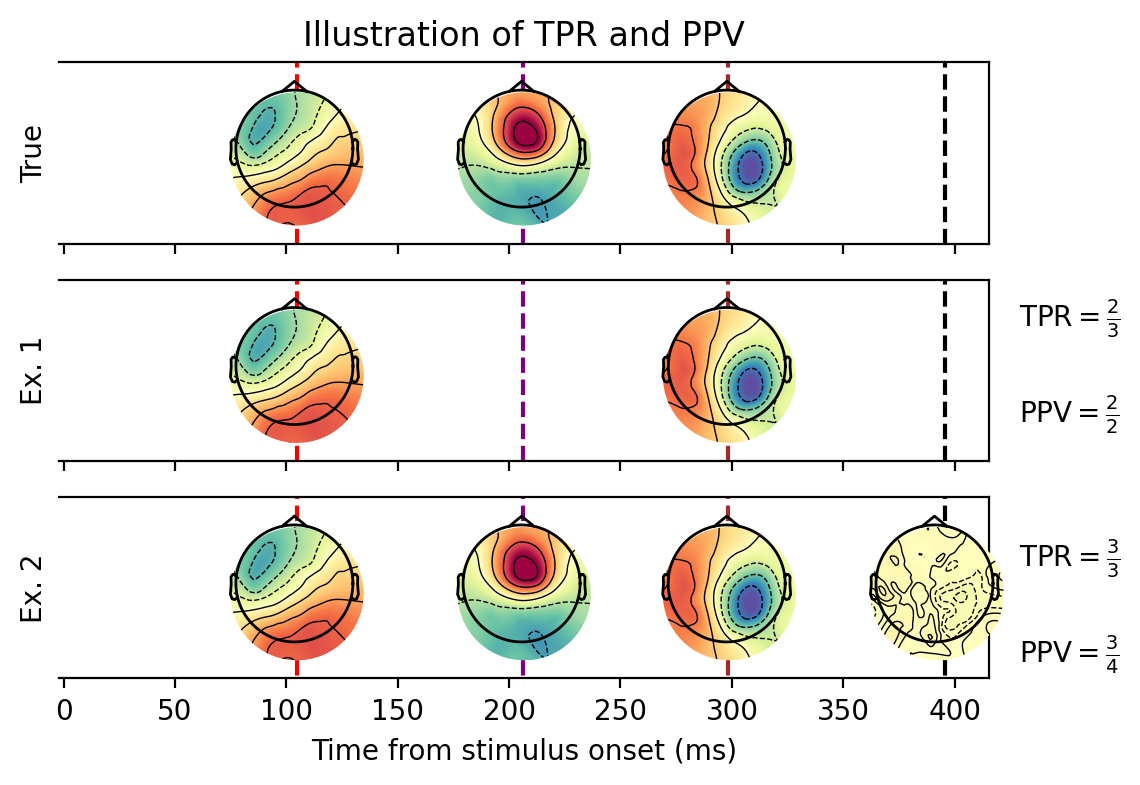

In [41]:
fig, ax = plt.subplots(3,1,  figsize=(6,4),sharex=True, dpi=200)

# estimates = init.fit()
hmp.visu.plot_topo_timecourse(epoch_data, estimates, info, init, magnify=2, ax=ax[0], sensors=False, as_time=True, 
    times_to_display = np.mean(np.cumsum(random_source_times,axis=1),axis=0), colorbar=False, cmap='Spectral_r', vmin=-7e-6,vmax=7e-6,
                             linecolors=['red', 'purple','brown','black'], event_lines=None)

ax[0].set_title('Illustration of TPR and PPV')
ax[0].set_ylabel('True')

# under_estimates = init.fit_single(2)
hmp.visu.plot_topo_timecourse(epoch_data, under_estimates, info, init, magnify=2, ax=ax[1], sensors=False, as_time=True, 
    times_to_display = np.mean(np.cumsum(random_source_times,axis=1),axis=0), colorbar=False, cmap='Spectral_r', vmin=-7e-6,vmax=7e-6,
                             linecolors=['red', 'purple','brown','black'], event_lines=None)
poor_parameters =  np.array([[2,50],[2,50],[2,50],[2,50],[2,5]])
# poor_estimates = init.fit_single(4, parameters=poor_parameters)
hmp.visu.plot_topo_timecourse(epoch_data, poor_estimates, info, init, magnify=2, ax=ax[2], sensors=False, as_time=True, 
    times_to_display = np.mean(np.cumsum(random_source_times,axis=1),axis=0), colorbar=False, cmap='Spectral_r', vmin=-7e-6,vmax=7e-6,
                             linecolors=['red', 'purple','brown','black'], event_lines=None)

ax[1].set_ylabel('Ex. 1')
ax[2].set_ylabel('Ex. 2')


ax[2].set_xlabel('Time from stimulus onset (ms)')
plt.gcf().text(.925, .55, r'$\text{TPR} = \frac{2}{3}$')
plt.gcf().text(.925, .43, r'$\text{PPV} = \frac{2}{2}$')

plt.gcf().text(.925, 0.25, r'$\text{TPR} = \frac{3}{3}$')
plt.gcf().text(.925, 0.13, r'$\text{PPV} = \frac{3}{4}$')
plt.savefig('../../plots/hit_FA.png',dpi=600,transparent=True,bbox_inches='tight')
plt.show()

## Collecting and concatenating results from cluster

In [2]:
results = []
i = 0 
path = 'results_simulation_snr/'
for file in listdir(path):
    if 'results' in file:
        r_i = xr.load_dataset(path+file, engine='netcdf4')
        r_i['seed'] = r_i.seed
        results.append(r_i)
        i += 1
results = xr.concat(results, dim='iteration')
results = results.rename({'n_events':'Nevents','true_n_events':'TrueN','test_n_events':'TestN'})
results['Hit'] = results.hit.count('event')
results['PPV'] = (results['Hit']) / results.TestN
results['TPR'] = (results['Hit']) / results.TrueN
print(f'{len(results.where(np.isnan(results.TPR), drop=True).iteration)} simulations are Nan')
results = results.dropna(dim="iteration", how="any", subset=['TPR'])
results

4 simulations are Nan


<xarray.Dataset> Size: 37MB
Dimensions:           (iteration: 496, all_combination: 4, stage: 11,
                       event: 10, trial: 100, component: 5)
Coordinates:
    Nevents           (all_combination) int64 32B 1 3 5 10
Dimensions without coordinates: iteration, all_combination, stage, event,
                                trial, component
Data variables: (12/17)
    means             (iteration, all_combination, stage) float64 175kB nan ....
    amplitude         (iteration, all_combination) float64 16kB 4.02e-07 ... ...
    snr               (iteration, all_combination) float64 16kB 33.57 ... 0.2114
    TrueN             (iteration, all_combination) float64 16kB 1.0 3.0 ... 10.0
    TestN             (iteration, all_combination) float64 16kB 1.0 3.0 ... 4.0
    loglikelihood     (iteration, all_combination) float64 16kB -134.3 ... -1...
    ...                ...
    gen_mags          (iteration, all_combination, event, component) float64 794kB ...
    recov_mags        (iteration, all_combination, event, component) float64 794kB ...
    seed              (iteration) int64 4kB 175 285 79 325 69 ... 392 120 58 389
    Hit               (iteration, all_combination) int64 16kB 1 3 5 5 ... 2 4 4
    PPV               (iteration, all_combination) float64 16kB 1.0 1.0 ... 1.0
    TPR               (iteration, all_combination) float64 16kB 1.0 1.0 ... 0.4
Attributes:
    distribution:  gamma
    shape:         2
    sfreq:         100
    n_comp:        5
    event_width:   50
    n_trials:      100
    seed:          175

## Modelling TPR and PPV

In [3]:
Nevents_df = results.groupby('all_combination').mean(('trial','component','stage','event')).to_dataframe().reset_index()
Nevents_df['SNR'] = np.log10(Nevents_df.snr)
#For easiness of fit and interpretability we convert tolerance to unit: 1e-02 = 1, 1e-03 = 2,...
# Nevents_df['Tolerance'] = Nevents_df['tolerances'].replace(Nevents_df['tolerances'].unique(), np.arange(len(Nevents_df['tolerances'].unique()))-len(Nevents_df['tolerances'].unique()))
Nevents_df['Nevents'] -= 3 #Intercept is 3 events for convenience also with other simulation sections

rec_model = bmb.Model("p(Hit, TrueN) ~ SNR  * Nevents", Nevents_df, family="binomial")
ppv_model = bmb.Model("p(Hit, TestN) ~ SNR * Nevents", Nevents_df, family="binomial")

In [4]:
rec_fit = fit_or_load('rec_model_amp-to-nev.nc', 'bambi_fits/',rec_model)
ppv_fit = fit_or_load('ppv_model_amp-to-nev.nc', 'bambi_fits/', ppv_model)

Compiling...
Compilation time = 0:00:01.558205
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:03.448376
Transforming variables...
Transformation time = 0:00:00.072828
Compiling...
Compilation time = 0:00:01.120163
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time = 0:00:03.152387
Transforming variables...
Transformation time = 0:00:00.044160


## Generating predictions for plotting

In [5]:
def len_prod(a,b):
    return len(list(product(a, b)))

SNR = np.linspace(Nevents_df.SNR.min(), Nevents_df.SNR.max(),  num=100)
# Tolerance = Nevents_df.Tolerance.unique()
Nevents = Nevents_df.Nevents.unique()

new_data = pd.DataFrame({
    "SNR": np.repeat(SNR, len(Nevents)),
    # "Tolerance": np.repeat(Tolerance, len_prod(SNR, Nevents)),
    "Nevents": np.tile(Nevents,len(SNR))
})

In [6]:
rec_model.predict(rec_fit, data=new_data)
rec_posterior = az.extract(rec_fit, num_samples=2000)['p(Hit, TrueN)_mean']

ppv_model.predict(ppv_fit, data=new_data)
ppv_posterior = az.extract(ppv_fit, num_samples=2000)['p(Hit, TestN)_mean']

## Inspecting summary

In [7]:
az.summary(rec_fit, hdi_prob=.95, var_names=list(list(rec_fit.posterior.data_vars.keys()))[:-1])

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,2.991,0.123,2.760,3.240,0.005,0.004,535.0,960.0,1.00
SNR,3.759,0.139,3.491,4.025,0.006,0.004,598.0,786.0,1.01
Nevents,-0.350,0.019,-0.388,-0.315,0.001,0.001,585.0,979.0,1.00
SNR:Nevents,-0.310,0.021,-0.351,-0.269,0.001,0.001,657.0,815.0,1.00


In [8]:
az.summary(ppv_fit, hdi_prob=.95, var_names=list(list(rec_fit.posterior.data_vars.keys()))[:-1])

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,4.211,0.208,3.817,4.629,0.005,0.004,1599.0,1610.0,1.0
SNR,3.259,0.207,2.864,3.674,0.005,0.004,1525.0,1474.0,1.0
Nevents,0.282,0.064,0.157,0.403,0.002,0.001,1492.0,1641.0,1.0
SNR:Nevents,0.113,0.056,0.004,0.223,0.001,0.001,1504.0,1611.0,1.0


## Plotting predictions

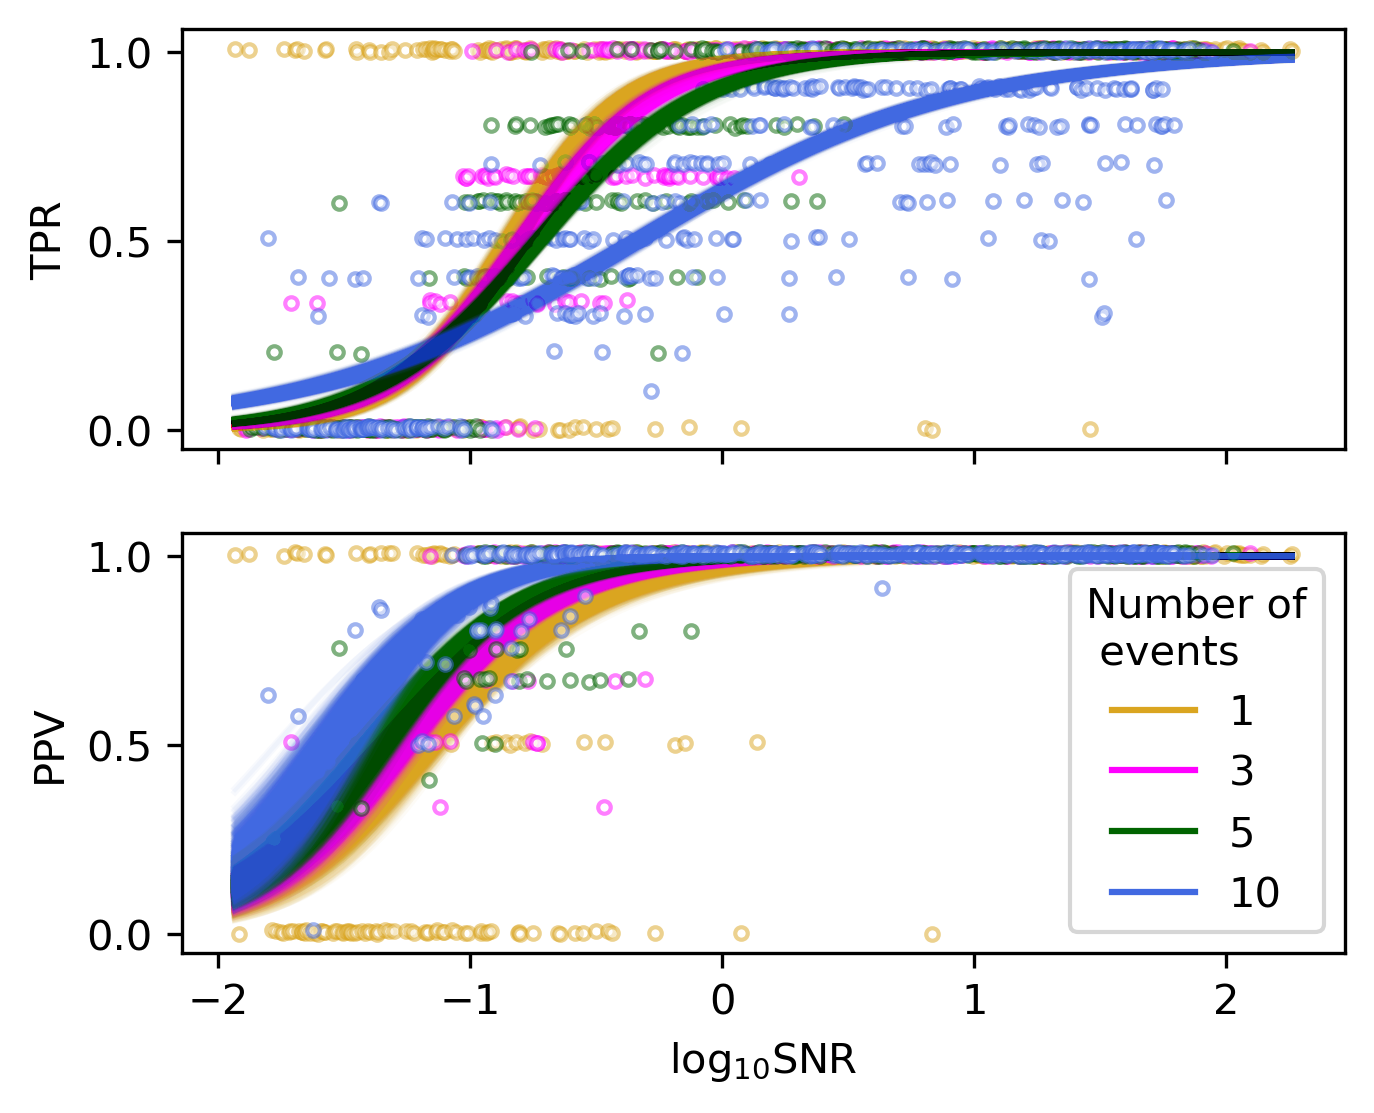

In [9]:
fig, ax = plt.subplots(2, 1, dpi=300, figsize=(5, 4), sharey=True, sharex=True)

colors = ['royalblue', 'darkgreen', 'magenta', 'goldenrod'][::-1]

for i, n_ev in enumerate(Nevents):
    c = colors[i]
    idx = new_data.index[new_data["Nevents"] == n_ev].tolist()
    ax[0].plot(SNR, rec_posterior[idx], alpha=0.02, color=c, zorder=10)

    subset = Nevents_df[Nevents_df.Nevents == n_ev].sort_values(by='snr')
    x = subset.SNR.copy()
    y = subset.TPR
    ax[0].plot(x, y + np.random.uniform(0, 1e-2, len(x)), '.', color=c, alpha=.5, mfc='w', ms=6)
    
    y = subset.PPV
    ax[1].plot(x, y + np.random.uniform(0, 1e-2, len(x)), '.', color=c, alpha=.5, mfc='w', ms=6)
    ax[1].plot(SNR, ppv_posterior[idx], alpha=0.04, color=c)

for color, n_ev in zip(colors, Nevents):
    ax[1].plot([],[], c=color, label=n_ev+3)

ax[1].legend(title='Number of\n events', loc='lower right', frameon=True)
ax[0].set_ylabel('TPR')
ax[0].set_yticks([0, .5, 1])
ax[1].set_ylabel('PPV')
ax[1].set_yticks([0, .5, 1])
ax[1].set_xlabel(r'log$_{10}$SNR')
# ax[0].set_xlim(-8, -6)
plt.savefig('../../plots/amp-tol-nev.png',dpi=300,transparent=True,bbox_inches='tight')
plt.show()